In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=21f8312421a5ed63ec16da75f3a6c84cbd9cf5f3b84512811b27b273f03ef346
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
"""
To evaluate the equitable prediction of transplant survival outcomes,
we use the concordance index (C-index) between a series of event
times and a predicted score across each race group.
 
It represents the global assessment of the model discrimination power:
this is the model’s ability to correctly provide a reliable ranking
of the survival times based on the individual risk scores.
 
The concordance index is a value between 0 and 1 where:
 
0.5 is the expected result from random predictions,
1.0 is perfect concordance (with no censoring, otherwise <1.0),
0.0 is perfect anti-concordance (with no censoring, otherwise >0.0)

"""

import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)

Test shape: (3, 58)
Train shape: (28800, 60)


In [5]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [6]:
train.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,24606.000000,28800.000000,24499.000000,26992.000000,26235.000000,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,1.773795,2015.179444,1.703743,42.511591,1.719916,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,0.427130,3.153914,0.462213,15.251434,0.454449,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2008.000000,0.000000,18.010000,0.000000,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,2.000000,2013.000000,1.000000,28.447000,1.000000,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2016.000000,2.000000,40.063000,2.000000,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2018.000000,2.000000,56.131500,2.000000,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2020.000000,2.000000,84.800000,2.000000,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [8]:
train[['efs', 'efs_time']]

,efs,efs_time
0,0.0,42.356
1,1.0,4.672
2,0.0,19.793
3,0.0,102.349
4,0.0,16.223
...,...,...
28795,0.0,18.633
28796,1.0,4.892
28797,0.0,23.157
28798,0.0,52.351


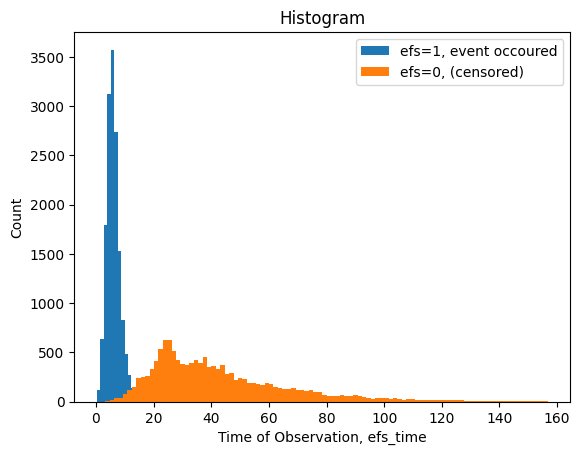

In [11]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, event occoured")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, (censored)")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Count")
plt.title("Histogram")
plt.legend()
plt.show()

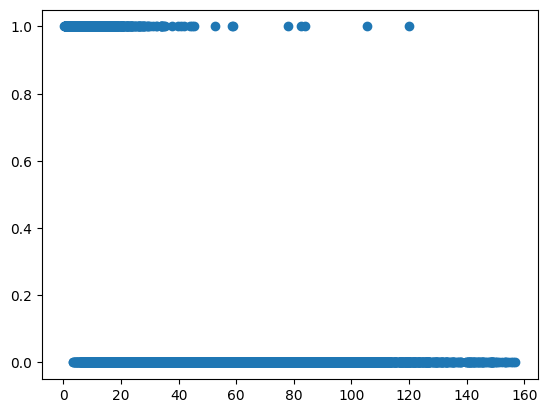

In [12]:
plt.scatter(train['efs_time'], train['efs'])
plt.show()

In [73]:
from lifelines import KaplanMeierFitter

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

In [74]:
train['y'] = transform_survival_probability(train, 'efs_time', 'efs')

In [75]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,0.458687
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,0.847759
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,0.462424
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,0.456661
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,0.464674


In [76]:
to_rmv =['ID', 'efs', 'efs_time', 'y']
features = [col for col in train.columns if not col in to_rmv]
target = 'y'
print(f'There are {len(features)} features')

There are 57 features


In [77]:
cat = [c for c in features if train[c].dtype == 'object']
print(f'There are {len(cat)} catagorial features')

There are 35 catagorial features


In [78]:
train[cat].columns

Index(['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status',
       'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe',
       'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab',
       'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity',
       'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe',
       'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match',
       'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'cardiac', 'pulm_moderate'],
      dtype='object')

In [79]:
num = [c for c in features if train[c].dtype != 'object']
print(f'There are {len(num)} numerical features')

There are 22 numerical features


In [80]:
train[num].columns

Index(['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6',
       'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6',
       'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low',
       'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low',
       'age_at_hct', 'hla_match_a_low', 'hla_match_b_high',
       'comorbidity_score', 'karnofsky_score', 'hla_low_res_8',
       'hla_match_drb1_high', 'hla_low_res_10'],
      dtype='object')

In [81]:
for c in cat:
    print(train[c].value_counts())
    print('-'*50)

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing disease status                                   9
Name: count, dtype: int64
--------------------------------------------------
psych_disturb
No          23005
Yes          3587
Not done      146
Name: count, dtype: int64
--------------------------------------------------
cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Oth

From the cat we have
1) Label encode
* dri_score 
2) One hot encode

# try: apply label encoder for all cat features

In [82]:
# from sklearn.preprocessing import LabelEncoder

# encoder = LabelEncoder()

# # Apply LabelEncoder only on the training set and then use it on the test set
# for column in categorical_columns:
#     # Fit the encoder on the training data
#     encoder.fit(train[column].astype(str))
    
#     # Transform both the training and test data using the same encoder
#     train[column] = encoder.transform(train[column].astype(str))
#     test[column] = encoder.transform(test[column].astype(str))  # Apply transformation on test set as well

#     # Ensure the encoded values are integers
#     train[column] = train[column].astype('int32')
#     test[column] = test[column].astype('int32')

#     # Optionally, convert to 'category' dtype if needed for memory efficiency
#     train[column] = train[column].astype('category')
#     test[column] = test[column].astype('category')

# test = test.drop(columns='y')

In [83]:
# train.head()

In [84]:
# train[features].isnull().sum()

In [85]:
# import warnings
# warnings.filterwarnings("ignore")

# def convert_64_to_32(df, num_features):
#     for c in num_features:
#         if df[c].dtype == 'float64':
#             df[c] = df[c].astype('float32')
#         else:
#             df[c] = df[c].astype('int32')
#     return df

# train = convert_64_to_32(train, num)
# test = convert_64_to_32(test, num)

In [86]:
# train.info()

# Feature eng: Handle missing values

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [88]:
train[cat].isnull().sum()

dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
tbi_status                    0
arrhythmia                 2202
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
cmv_status                  634
tce_imm_match             11133
rituximab                  2148
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
obesity                    1760
mrd_hct                   16597
in_vivo_tcd                 225
tce_match                 18996
hepatic_severe             1871
prior_tumor                1678
peptic_ulcer               2419
gvhd_proph                  225
rheum_issue                2183
sex_match                   261
race_group                    0
hepatic_mild               1917
tce_div_match             11396
donor_re

In [89]:
for c in cat:
    train[c].fillna('Missing', inplace=True)
    test[c].fillna('Missing', inplace=True)

In [90]:
train[cat].isnull().sum()

dri_score                 0
psych_disturb             0
cyto_score                0
diabetes                  0
tbi_status                0
arrhythmia                0
graft_type                0
vent_hist                 0
renal_issue               0
pulm_severe               0
prim_disease_hct          0
cmv_status                0
tce_imm_match             0
rituximab                 0
prod_type                 0
cyto_score_detail         0
conditioning_intensity    0
ethnicity                 0
obesity                   0
mrd_hct                   0
in_vivo_tcd               0
tce_match                 0
hepatic_severe            0
prior_tumor               0
peptic_ulcer              0
gvhd_proph                0
rheum_issue               0
sex_match                 0
race_group                0
hepatic_mild              0
tce_div_match             0
donor_related             0
melphalan_dose            0
cardiac                   0
pulm_moderate             0
dtype: int64

In [92]:
for c in cat:
    print(train[c].value_counts())
    print('-'*50)

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing                                                154
Missing disease status                                   9
Name: count, dtype: int64
--------------------------------------------------
psych_disturb
No          23005
Yes          3587
Missing      2062
Not done      146
Name: count, dtype: int64
--------------------------------------------------
cyto_score
Poor            8802
Missing   

In [93]:
def clean_not_done(df):
    df = df.applymap(lambda x: 'Missing' if x == 'Not done' else x)
    return df

def clean_not_tested(df):
    df = df.applymap(lambda x: 'Missing' if x == 'Not tested' else x)
    return df
    
def clean_dri_score(score):
    if isinstance(score, str) and 'Missing disease status' in score:
        return 'Missing'
    return score

def clean_conditioning_intensity(score):
    if isinstance(score, str) and 'No drugs reported' in score:
        return 'Missing'
    return score

In [94]:
train = clean_not_done(train)
test = clean_not_done(test)

train = clean_not_tested(train)
test = clean_not_tested(test)

<ipython-input-93-c3b0b5f59a9d>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 'Missing' if x == 'Not done' else x)
<ipython-input-93-c3b0b5f59a9d>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 'Missing' if x == 'Not tested' else x)


In [95]:
train['dri_score'] = train['dri_score'].apply(clean_dri_score)
test['dri_score'] = test['dri_score'].apply(clean_dri_score)

In [96]:
train['conditioning_intensity']

0        Missing
1            MAC
2        Missing
3            MAC
4            MAC
          ...   
28795        MAC
28796        RIC
28797        MAC
28798        NMA
28799    Missing
Name: conditioning_intensity, Length: 28800, dtype: object

In [97]:
train['conditioning_intensity'] = train['conditioning_intensity'].apply(clean_conditioning_intensity)
test['conditioning_intensity'] = test['conditioning_intensity'].apply(clean_conditioning_intensity)


In [98]:
for c in cat:
    print(train[c].value_counts())
    print('-'*50 + '\n')

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing                                                163
Name: count, dtype: int64
--------------------------------------------------

psych_disturb
No         23005
Yes         3587
Missing     2208
Name: count, dtype: int64
--------------------------------------------------

cyto_score
Poor            8802
Missing         8123
Intermediate    6376
Favorable       3011
TBD             1341
Norm

# LightGBM

In [99]:
train[cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   dri_score               28800 non-null  object
 1   psych_disturb           28800 non-null  object
 2   cyto_score              28800 non-null  object
 3   diabetes                28800 non-null  object
 4   tbi_status              28800 non-null  object
 5   arrhythmia              28800 non-null  object
 6   graft_type              28800 non-null  object
 7   vent_hist               28800 non-null  object
 8   renal_issue             28800 non-null  object
 9   pulm_severe             28800 non-null  object
 10  prim_disease_hct        28800 non-null  object
 11  cmv_status              28800 non-null  object
 12  tce_imm_match           28800 non-null  object
 13  rituximab               28800 non-null  object
 14  prod_type               28800 non-null  object
 15  cy

In [101]:
from sklearn.preprocessing import LabelEncoder

for c in cat:
    encoder = LabelEncoder()
    # Fit and transform the training data
    train[c] = train[c].astype(str)
    train[c] = encoder.fit_transform(train[c])
    train[c] = train[c].astype('int32')
    train[c] = train[c].astype('category')
    
    # Transform the test data using the encoder fitted on the training data
    test[c] = test[c].astype(str)
    test[c] = encoder.transform(test[c])  # Use the fitted encoder
    test[c] = test[c].astype('int32')
    test[c] = test[c].astype('category')
    

def convert_64_to_32(df, num_features):
    for c in num_features:
        if df[c].dtype == 'float64':
            df[c] = df[c].astype('float32')
        else:
            df[c] = df[c].astype('int32')
    return df

train = convert_64_to_32(train, num)
test = convert_64_to_32(test, num)

In [102]:
train[target]

0        0.458687
1        0.847759
2        0.462424
3        0.456661
4        0.464674
           ...   
28795    0.462846
28796    0.825494
28797    0.461142
28798    0.458404
28799    0.460616
Name: y, Length: 28800, dtype: float64

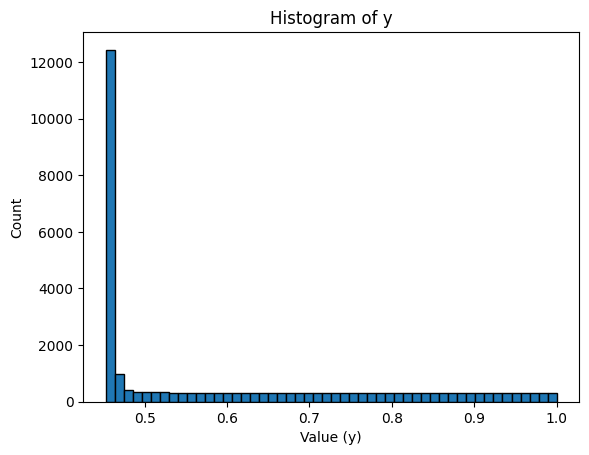

In [103]:
plt.hist(train[target], bins=50, edgecolor='k')
plt.xlabel('Value (y)')
plt.ylabel('Count')
plt.title('Histogram of y')
plt.show()

In [104]:
%%time
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import *
import lightgbm as lgb
from lightgbm import LGBMRegressor

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (tr_idx, va_idx) in enumerate(kf.split(train)):
    
    X_train = train.loc[tr_idx, features].copy()
    y_train = train.loc[tr_idx, target]
    X_valid = train.loc[va_idx, features].copy()
    y_valid = train.loc[va_idx, target]
    X_test = test[features].copy()

    model_lgb = LGBMRegressor(
        device="gpu",
        max_depth=3,
        colsample_bytree=0.4,  
        cat_features=cat,
        n_estimators=5000, 
        learning_rate=0.02, 
        objective="regression", 
        verbose=-1, 
        early_stopping_rounds=20,
    )
    
    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)]
    )

    valid_preds = model_lgb.predict(X_valid)
    oof_lgb[va_idx] = valid_preds
    pred_lgb += model_lgb.predict(X_test)
    fold_rmse = mean_squared_error(y_valid, valid_preds, squared=False)
    
    print("#"*25)
    print(f"### Fold {i+1} \n")
    print(f"Fold {i+1} RMSE: {fold_rmse}")
    print("#"*25)

pred_lgb /= FOLDS

#########################
### Fold 1 

Fold 1 RMSE: 0.15631619784873158
#########################
#########################
### Fold 2 

Fold 2 RMSE: 0.1539098144283682
#########################
#########################
### Fold 3 

Fold 3 RMSE: 0.15527197134989207
#########################
#########################
### Fold 4 

Fold 4 RMSE: 0.15741729087256273
#########################
#########################
### Fold 5 

Fold 5 RMSE: 0.15486697961150594
#########################
#########################
### Fold 6 

Fold 6 RMSE: 0.1582225530018047
#########################
#########################
### Fold 7 

Fold 7 RMSE: 0.15974586319233014
#########################
#########################
### Fold 8 

Fold 8 RMSE: 0.1556632483897407
#########################
#########################
### Fold 9 

Fold 9 RMSE: 0.15790147788000505
#########################
#########################
### Fold 10 

Fold 10 RMSE: 0.15567121654447164
#########################
CPU times: user 1min 

In [105]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true, y_pred, "ID")
print(f"\nOverall CV for KaplanMeier =", m)

# Overall CV for KaplanMeier = 0.6715785706217949

<ipython-input-15-a1aa375cd29b>:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for KaplanMeier = 0.6712168895301276


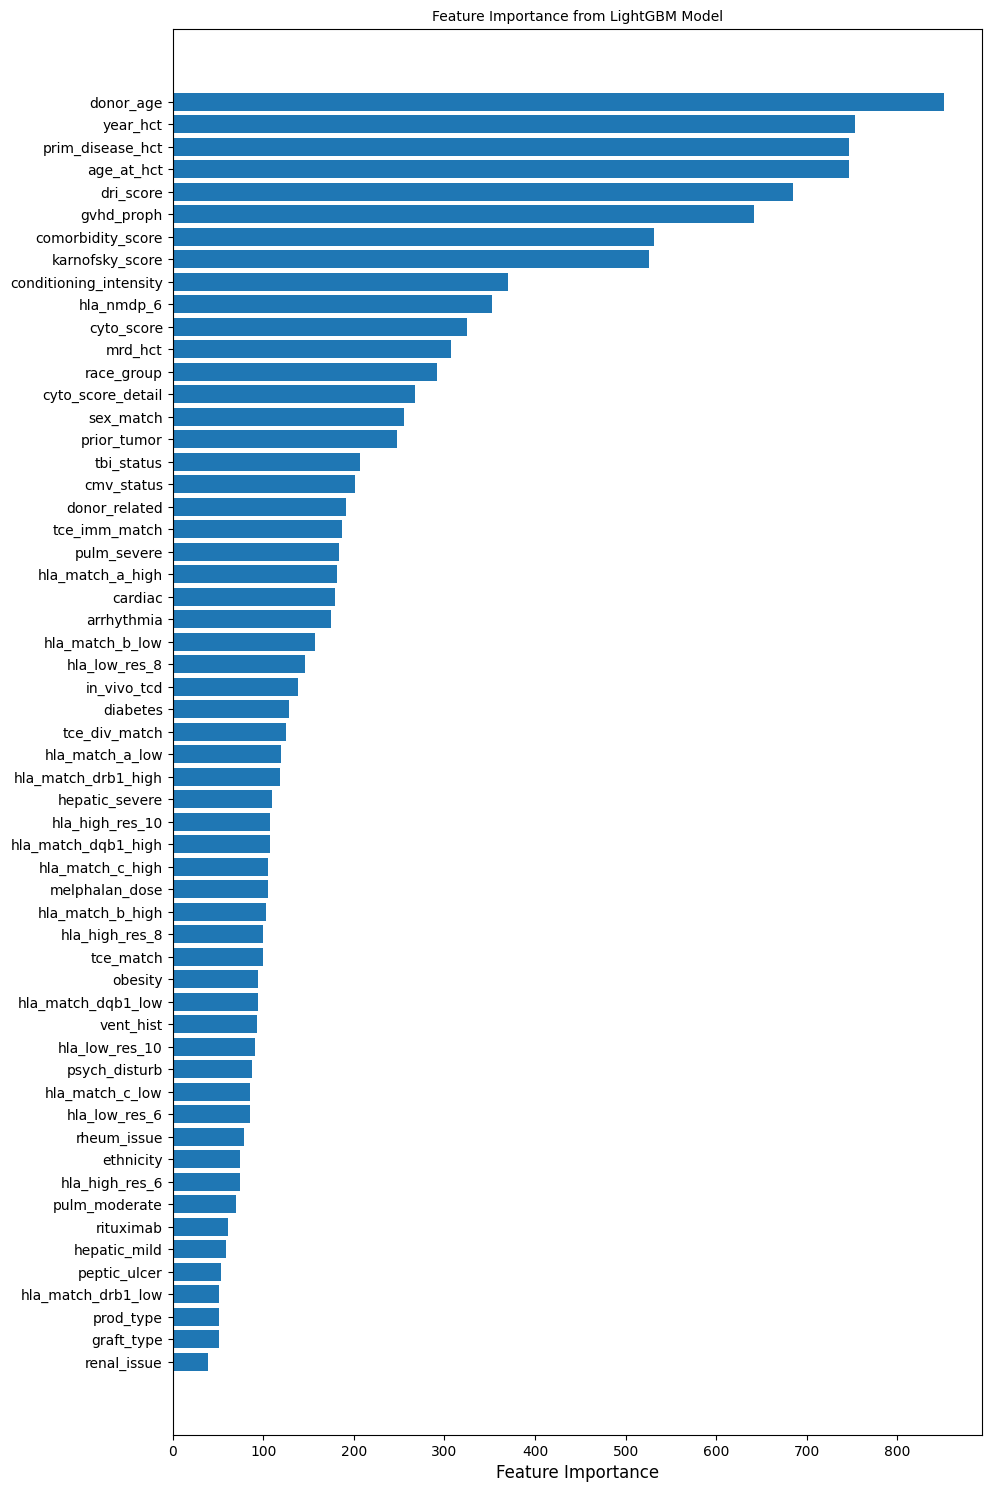

In [106]:
feature_importance = model_lgb.feature_importances_

# Get the feature names from the model (replace with actual feature names if needed)
feature_names = model_lgb.feature_name_

# Sort the feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Plotting
plt.figure(figsize=(10, 15))  # Increase the figure size for more room
plt.barh(range(len(feature_importance)), feature_importance[indices], align='center')
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in indices], fontsize=10)  # Adjust font size for clarity
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance from LightGBM Model', fontsize=10)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Adjust layout for padding
plt.tight_layout(pad=1.0)

plt.show()

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')

In [43]:
submission = sample_submission.copy()
submission['prediction'] = pred_lgb

In [ ]:
submission.to_csv('/kaggle/working/submission.csv', index=False)
submission